<a href="https://colab.research.google.com/github/xli2522/simple-BBH-waveform/blob/main/simple_BBH_waveform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

##1. Merger Frequency Ranges of BBH Systems

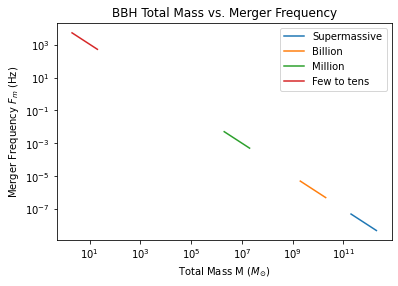

[[5.16350420215902e-08, 5.163504202159019e-09], [5.163504202159019e-06, 5.163504202159021e-07], [0.00516350420215902, 0.000516350420215902], [5163.50420215902, 516.350420215902]]


In [2]:
# Frequency ranges of BBH mergers
def fmerger(M):
    '''Calculates the merger freuqency of a BBH system given the total mass M of the system
    '''
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    R = 1.7               # compactness ratio
    freq = (c**3)/(R**(3/2)*2**(3/2)*G*M*1.989*10**30)/(np.pi)     # merger frequency formula

    return freq

# Calculate the frequency ranges of 
ranges = []; masses = []
# 1. Supermassive 10**11 Msolar
Mmin = 2*10**11; Mmax = 2*10**12
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 2. Billion Msolar
Mmin = 2*10**9; Mmax = 2*10**10
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 3. Million Msolar
Mmin = 2*10**6; Mmax = 2*10**7
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])
# 4. Few to tens Msolar
Mmin = 2; Mmax = 20
ranges.append([fmerger(Mmin), fmerger(Mmax)])
masses.append([Mmin, Mmax])

for i in range(len(ranges)):
    plt.plot(masses[i], ranges[i])
plt.legend(['Supermassive', 'Billion','Million', 'Few to tens'])
plt.title('BBH Total Mass vs. Merger Frequency')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'Total Mass M ($M_{\odot}$)')
plt.ylabel(r'Merger Frequency $F_m$ (Hz)')
plt.show()

print(ranges)

##2. Individual Mass Estimation of GW150914

In [3]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

     |████████████████████████████████| 27.3 MB 1.5 MB/s 
     |████████████████████████████████| 6.3 MB 10.6 MB/s 
     |████████████████████████████████| 1.4 MB 25.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 201 kB 54.7 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 295 kB 59.4 MB/s 
     |████████████████████████████████| 3.6 MB 54.0 MB/s 


###2.1 Obtain GW150914 Data from LIGO Database

In [4]:
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

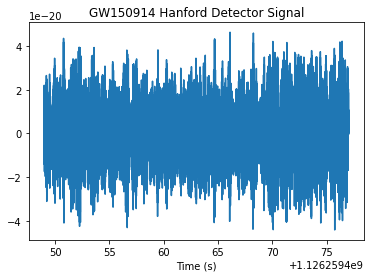

In [5]:
merger = Merger("GW150914")

# Get the data from H and L detectors
hdata = merger.strain('H1')
ldata = merger.strain('L1')

# Frequency pass filter and downsample the data to 2048Hz 
rate = 2048
# (normally 4096Hz is used but in this simple calculation the sampling Freq can be lower)
hdata = highpass(hdata, 15.0)       # remove some lower freq components
hdata = resample_to_delta_t(hdata, 1.0/rate)

ldata = highpass(ldata, 15.0)       # remove some lower freq components
ldata = resample_to_delta_t(ldata, 1.0/rate)

# crop the signal
conditionedhdata = hdata.crop(2, 2); conditionedldata = ldata.crop(2, 2)
pylab.plot(conditionedhdata.sample_times, conditionedhdata)
pylab.xlabel('Time (s)')
pylab.title('GW150914 Hanford Detector Signal')
pylab.show()

In [6]:
# Here are some steps taken to reduce the further reduce the signal noise

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density
# the PSDs are used in the denoising step (strain whitening)
psdh = conditionedhdata.psd(4); psdl = conditionedldata.psd(4)       # take the first 4 seconds of data and calculate the psd
psdh = interpolate(psdh, conditionedhdata.delta_f); psdl = interpolate(psdl, conditionedldata.delta_f)       # interpolate the resutl to the proper length
psdh = inverse_spectrum_truncation(psdh, int(4 * conditionedhdata.sample_rate), low_frequency_cutoff=15)
psdl = inverse_spectrum_truncation(psdl, int(4 * conditionedldata.sample_rate), low_frequency_cutoff=15)

In [7]:
# Here are some Signal to Noise ratio (SNR) and merger time data avaliable on GW150914
# we skip the calculation here
snrp = 19.677089013145903         # peak SNR
time = 1126259462.4248047         # peak time

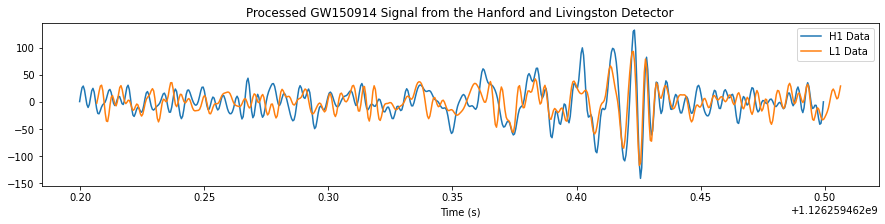

In [8]:
# Data whitening as a step of denoising
white_hdata = (conditionedhdata.to_frequencyseries() / psdh**0.5).to_timeseries()
white_ldata = (conditionedldata.to_frequencyseries() / psdl**0.5).to_timeseries()

# Apply high pass and low pass (frequency) filter again; keep [30Hz, 300Hz]
white_hdata = white_hdata.highpass_fir(30., 500).lowpass_fir(300, 1000)
white_ldata = white_ldata.highpass_fir(30., 500).lowpass_fir(300, 1000)

# Select the time around the merger (0.2 s before, 0.1 s after)
white_hdata = white_hdata.time_slice(merger.time-.2, merger.time+.1)
white_ldata = white_ldata.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.title('Processed GW150914 Signal from the Hanford and Livingston Detector')
pylab.plot(white_hdata.sample_times, white_hdata, label="H1 Data")
# Here we invert the L1 data and shift L1 data forward by 6.9 ms to match the t_merger
pylab.plot(white_ldata.sample_times+0.0069, -white_ldata, label="L1 Data")
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

### 2.2 Estimate Instantaneous Frequencies (IFs)

In [9]:
# identify the zero-crossings in the detector signal
white_hdata_crop = white_hdata[int(0.15*rate):int(0.23*rate)]+5; white_ldata_crop = white_ldata[int((0.15-0.0069)*rate):int((0.23-0.0069)*rate)]-5      # elevate signals
print(white_hdata_crop.shape)
zero_hcrossings = np.where(np.diff(np.sign(white_hdata_crop)))[0]; zero_lcrossings = np.where(np.diff(np.sign(white_ldata_crop)))[0] 
print(zero_hcrossings); print(zero_lcrossings)        # zero-crossing positions in the siganl

(164,)
[  5  13  21  38  58  79  92  93  98 111 127 138 146 153 158]
[ 11  34  39  43  53  58  60  79  97 113 123 137 145 152 157]


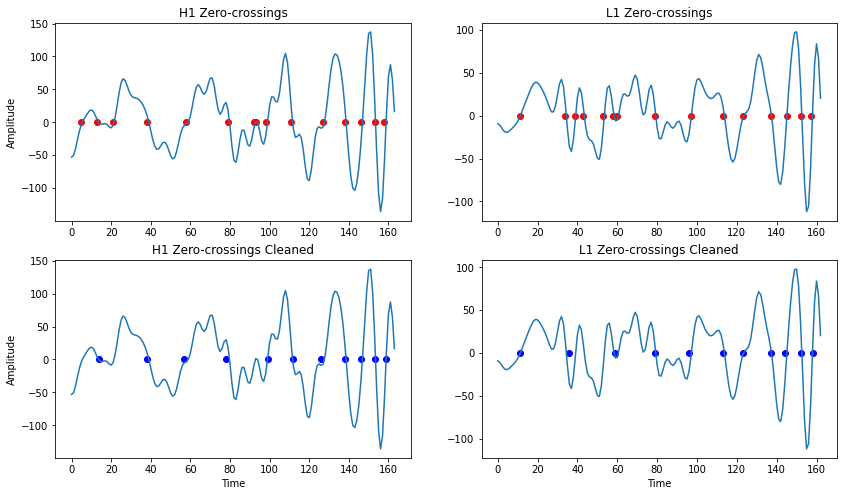

In [10]:
# plot the zero-crossings
fig, ax = plt.subplots(2,2)
fig.set_size_inches(14, 8)
ax[0,0].plot(white_hdata_crop)
ax[0,0].scatter(zero_hcrossings, np.zeros(len(zero_hcrossings)), c='r')
#ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('H1 Zero-crossings')
ax[0,1].plot(-white_ldata_crop)
ax[0,1].scatter(zero_lcrossings, np.zeros(len(zero_lcrossings)), c='r')
#ax[0,1].set_xlabel('Time')
ax[0,1].set_title('L1 Zero-crossings')

zero_hcrossings_clean = [  14, 38,57,  78 , 99, 112, 126 ,138, 146, 153 ,159 ]              # referenced 200 lowpass signal zero-crossings
zero_lcrossings_clean = [ 11, 36 , 59,  79,  96 ,113, 123, 137, 144 ,152, 158]              # referenced 200 lowpass signal zero-crossing
ax[1,0].plot(white_hdata_crop)
ax[1,0].scatter(zero_hcrossings_clean, np.zeros(len(zero_hcrossings_clean)), c='b')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_title('H1 Zero-crossings Cleaned')
ax[1,1].plot(-white_ldata_crop)
ax[1,1].scatter(zero_lcrossings_clean, np.zeros(len(zero_lcrossings_clean)), c='b')
ax[1,1].set_xlabel('Time')
ax[1,1].set_title('L1 Zero-crossings Cleaned')

plt.show()
IF_sample = [42, 47, 50, 43, 55, 71,74,86,120,195]

[ 42.66666667  53.89473684  48.76190476  48.76190476  78.76923077
  73.14285714  85.33333333 128.         146.28571429 170.66666667]
[ 40.96        44.52173913  51.2         60.23529412  60.23529412
 102.4         73.14285714 146.28571429 128.         170.66666667]


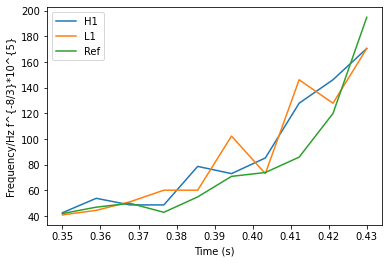

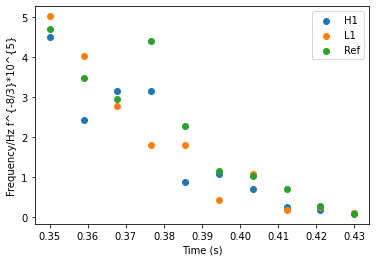

The estimated total mass is: 70.73293427615097solar mass.


In [11]:
IF_hdata = np.zeros(len(zero_hcrossings_clean)-1); IF_ldata = np.zeros(len(zero_lcrossings_clean)-1)
for i in range(len(zero_hcrossings_clean)-1):
    IF_hdata[i] = 1/(2*((zero_hcrossings_clean[i+1]-zero_hcrossings_clean[i])/2048))          #Kito
for i in range(len(zero_lcrossings_clean)-1):
    IF_ldata[i] = 1/(2*((zero_lcrossings_clean[i+1]-zero_lcrossings_clean[i])/2048))          #Kito

IF_hdata = np.asarray(IF_hdata); IF_ldata = np.asarray(IF_ldata)
print(IF_hdata); print(IF_ldata)
IF_sample = np.asarray(IF_sample)
plt.plot(np.linspace(0.35, 0.43, len(IF_hdata)),IF_hdata)
plt.plot(np.linspace(0.35, 0.43, len(IF_ldata)),IF_ldata)
plt.plot(np.linspace(0.35, 0.43, len(IF_sample)),IF_sample)
plt.legend(['H1','L1', 'Ref'])
plt.ylabel(r'Frequency/Hz f^{-8/3}*10^{5}')
plt.xlabel('Time (s)')
plt.show()

IF_hdata = IF_hdata**(-8/3)*10**5; IF_ldata = IF_ldata**(-8/3)*10**5; IF_sample = IF_sample**(-8/3)*10**5

plt.scatter(np.linspace(0.35, 0.43, len(IF_hdata)),IF_hdata)
plt.scatter(np.linspace(0.35, 0.43, len(IF_ldata)),IF_ldata)
plt.scatter(np.linspace(0.35, 0.43, len(IF_sample)),IF_sample)
plt.legend(['H1','L1', 'Ref'])
plt.ylabel(r'Frequency/Hz f^{-8/3}*10^{5}')
plt.xlabel('Time (s)')

plt.show()

# now estimate the total mass
c = 3*10**8           # speed of light
G = 6.674*10**(-11)   # gravitational constant
R = 1.7               # compactness ratio
freq_merger =  146
M_total = (c**3)/(R**(3/2)*2**(3/2)*G*freq_merger*1.989*10**30)/(np.pi)   
print(r'The estimated total mass is: '+str(M_total)+r'solar mass.')

In [12]:
! pip install lmfit

     |████████████████████████████████| 292 kB 2.9 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84402 sha256=6a408c9035aa46126c80ea8b2ef939bbe5e839a58e2369a2f35fe03d90e1382a
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
  Created wheel for asteval: filename=asteval-0.9.26-py3-none-any.whl size=17648 sha256=e4f4856c65534b96519f50d59e73e8554cb653543a88598aeb414f99f5bc8a09
  Stored in directory: /root/.cache/pip/wheels/4c/e9/f0/bc343d5b77d2fded45177f424a6b0b9224b92ff6e7c150bad4
Successfully built lmfit asteval


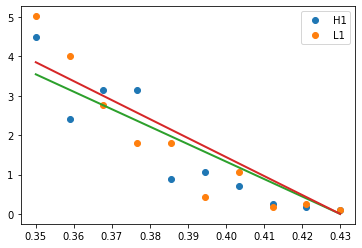

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 10
    # variables        = 1
    chi-square         = 4.26717518
    reduced chi-square = 0.47413058
    Akaike info crit   = -6.51633035
    Bayesian info crit = -6.21374526
[[Variables]]
    M_c:  29.8607052 +/- 1.85636424 (6.22%) (init = 0)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 10
    # variables        = 1
    chi-square         = 4.67401239
    reduced chi-square = 0.51933471
    Akaike info crit   = -5.60567206
    Bayesian info crit = -5.30308697
[[Variables]]
    M_c:  31.3849127 +/- 1.87941847 (5.99%) (init = 0)


In [13]:
# now we do a linear fit 
from lmfit import minimize, Parameters, Parameter, report_fit

def residual(ps, tc, data):
    M_c = ps['M_c'].value
    tc = tc               #tc = 0.08
    t = np.linspace(0, tc, len(data))
    tau = tc -t
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    model = (8*np.pi)**(8/3)/5*((G*M_c*1.989*10**30)/c**3)**(5/3)*(tau)*10**5
    
    return (model - data).ravel()

tc = 0.08
params = Parameters()
params.add('M_c', value=0)        # set the chirp mass as the only variable

result_h = minimize(residual, params, args=(tc, IF_hdata), method='leastsq')
final_h = IF_hdata + result_h.residual.reshape(IF_hdata.shape)

result_l = minimize(residual, params, args=(tc, IF_ldata), method='leastsq')
final_l = IF_ldata + result_l.residual.reshape(IF_ldata.shape)

plt.plot(np.linspace(0.35, 0.43, len(IF_hdata)),IF_hdata, 'o')
plt.plot(np.linspace(0.35, 0.43, len(IF_ldata)),IF_ldata, 'o')
plt.plot(np.linspace(0.35, 0.43, len(final_h)), final_h, '-', linewidth = 2)
plt.plot(np.linspace(0.35, 0.43, len(final_l)), final_l, '-', linewidth = 2)
plt.legend(['H1', 'L1'])
plt.show()
report_fit(result_h)
report_fit(result_l)
#  H1: M_c:  29.8607052 +/- 1.85636424 (6.22%) (init = 0)
#  H2: M_c:  31.3849127 +/- 1.87941847 (5.99%) (init = 0)
#  Average: (29.8607052+31.3849127)/2 = 30.62280895

In [14]:
! pip install TFchirp

/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-n ** 2 / sig2)
/usr/local/lib/python3.7/dist-packages/scipy/signal/windows/windows.py:1277: RuntimeWarning: invalid value encountered in true_divide
  w = np.exp(-n ** 2 / sig2)


(151, 615)


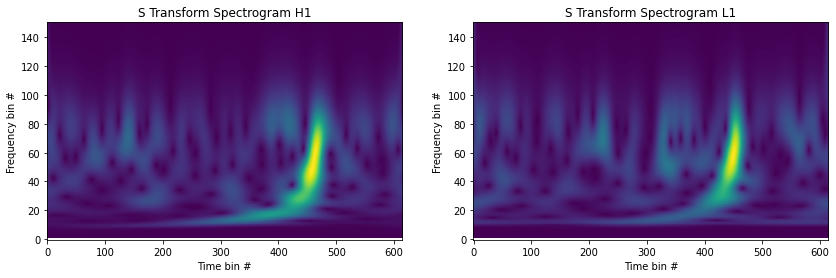

In [15]:
import TFchirp
spectrogramh = abs(TFchirp.sTransform(white_hdata, sample_rate=rate))
spectrograml = abs(TFchirp.sTransform(white_ldata, sample_rate=rate))
print(spectrogramh.shape)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 4)

ax[0].imshow(spectrogramh, origin='lower', aspect='auto')
ax[0].set_title('S Transform Spectrogram H1')
ax[0].set_xlabel('Time bin #')
ax[0].set_ylabel('Frequency bin #')
ax[1].imshow(spectrograml, origin='lower', aspect='auto')
ax[1].set_title('S Transform Spectrogram L1')
ax[1].set_xlabel('Time bin #')
ax[1].set_ylabel('Frequency bin #')
plt.show()

###2.3 Time Evolution of Orbital Frequency (test)

In [16]:
# frequency evolution (test)
def freq_gw(t):
    '''The frequency evolution function'''
    t = np.linspace(0.01, t, 100)
    tc = 1                # a random tc for testing
    tau = tc - t
    M = 25
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    freq_gw = (1/np.pi)*((5/(256*tau))**(3/8))*((G*M*1.989*10**30)/c**3)**(-5/8)

    return freq_gw

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


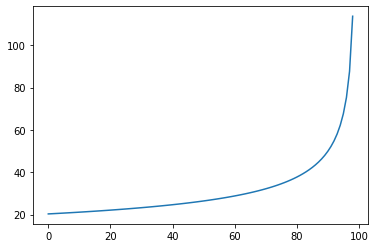

In [17]:
freq = freq_gw(1)       # test
plt.plot(freq)
plt.show()

#### Appendix 1.1 IF Estimation from the Spectrogram (tested but not ideal in this case)

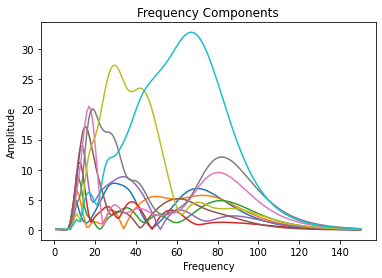

[29, 11, 12, 12, 13, 15, 17, 19, 30, 67]


In [18]:
# sample the signal with a constant time interval 
# from 200 time bin to 500 time bin 
samplesh = []          
for i in range(200, 500, 30):
    # only a limited number of elements, use python list for simplicity
    samplesh.append(spectrogramh[:,i])
    plt.plot(spectrogramh[:,i])
plt.title('Frequency Components')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# now collect peak frequencies (under the assumption that peak frequencies are the IFs of the BBH merger signal)
peaksh = []
for count in range(len(samplesh)):
    peaksh.append(int(np.where(samplesh[count] == max(samplesh[count][1:]))[0]))
print(peaksh)

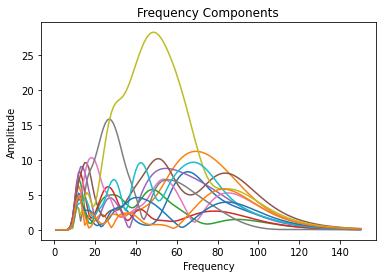

[65, 69, 12, 13, 14, 51, 18, 27, 49, 68, 40, 83]


In [19]:
# sample the signal with a constant time interval 
# from 200 time bin to 500 time bin 
samplesl = []          
for i in range(200, 560, 30):
    # only a limited number of elements, use python list for simplicity
    samplesl.append(spectrograml[:,i])
    plt.plot(spectrograml[:,i])
plt.title('Frequency Components')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# now collect peak frequencies (under the assumption that peak frequencies are the IFs of the BBH merger signal)
peaksl = []
for count in range(len(samplesl)):
    peaksl.append(int(np.where(samplesl[count] == max(samplesl[count][1:]))[0]))
print(peaksl)

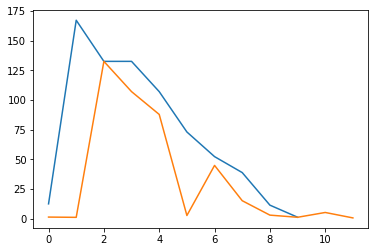

In [20]:
# plot the IF diagram
peaksh = np.asarray(peaksh); peaksl = np.asarray(peaksl)
rescaledh = peaksh**(-8/3)*10**5; rescaledl = peaksl**(-8/3)*10**5
plt.plot(range(len(rescaledh)), rescaledh); plt.plot(range(len(rescaledl)), rescaledl)
plt.show()